## Signature functions 

Davidson defined signature functions in his book Turbulence as,
\begin{equation}
V(r) = -\frac{r^2}{2}\frac{\partial}{\partial r}\frac{1}{r}\frac{\partial}{\partial r} \left[\frac{1}{2} <\delta v^2> \right].
\end{equation}
The constant factors take care of the normalizations. See the book for more details. 

Since signature functions are defined in terms of 2nd order derivatives, it is going to be tricking to evaluate them using observations. To partially alleviate the observational noise issue we will first fit a high order polynomial to the data.

In [1]:
import numpy as np

import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline


In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_GLAD = sio.loadmat('../../data/SF_GLAD_deep_500m.mat')
ds_LASER = sio.loadmat('../../data/SF_LASER_deep_500m.mat')

In [4]:
SF_GLAD = {'r': ds_GLAD['dist_axis'][0,:], 
           'S2ll': ds_GLAD['SF2ll'][0,:], 
           'S2tt': ds_GLAD['SF2tt'][0,:] }
#r = SF_glad['dist_axis'][0,:]
#yll = SF_glad['SF2ll'][0,:]
#ytt = SF_glad['SF2tt'][0,:]

In [5]:
SF_LASER = {'r': ds_LASER['dist_axis'][0,:], 
           'S2ll': ds_LASER['SF2ll'][0,:], 
           'S2tt': ds_LASER['SF2tt'][0,:] }

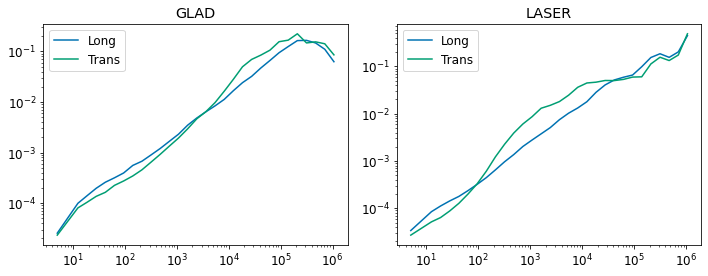

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['S2ll'], label='Long')
plt.plot(SF_GLAD['r'], SF_GLAD['S2tt'], label='Trans')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.title('GLAD')

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['S2ll'], label='Long')
plt.plot(SF_LASER['r'], SF_LASER['S2tt'], label='Trans')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.title('LASER')

plt.tight_layout()

### Helmholtz Decomposition

Do a helmholtz decomposition to separate the SF2 into rotational and divergent parts. 
This is done using the methods from Buhler et al 2014, and expanded to structure functions by Lindborg 2015.

In [7]:
from scipy import integrate

In [8]:
def helmholtz_decompose(r, SF2ll, SF2tt):
    # commented out old style code in favor of using trapezoidal rule.
    #dr = np.diff(r)
    #mid_r = 0.5*(r[0:-1]+r[1:])
    #mid_diff_du = 0.5*((SF2tt[0:-1] - SF2ll[0:-1])+(SF2tt[1:]-SF2ll[1:]))
    
    #SF2rr = np.zeros_like(mid_r)
    #SF2dd = np.zeros_like(mid_r)    
    

    #for i in range(1, len(r)):
    #    SF2rr[i-1] = SF2tt[i] + np.nansum(1./mid_r[0:i]*mid_diff_du[0:i]*dr[0:i])
    #    SF2dd[i-1] = SF2ll[i] - np.nansum(1./mid_r[0:i]*mid_diff_du[0:i]*dr[0:i])
    
    SF2rr = SF2tt + integrate.cumtrapz(1/r*(SF2tt - SF2ll), r, initial=0)
    SF2dd = SF2ll - integrate.cumtrapz(1/r*(SF2tt - SF2ll), r, initial=0)

    #return mid_r, SF2rr, SF2dd
    return SF2rr, SF2dd

In [9]:
SF_GLAD['S2rr'], SF_GLAD['S2dd'] = helmholtz_decompose(SF_GLAD['r'], SF_GLAD['S2ll'], SF_GLAD['S2tt'])
SF_LASER['S2rr'], SF_LASER['S2dd'] = helmholtz_decompose(SF_LASER['r'], SF_LASER['S2ll'], SF_LASER['S2tt'])

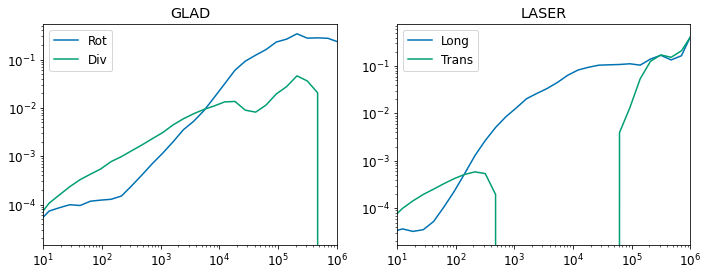

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['S2rr'], label='Rot')
plt.plot(SF_GLAD['r'], SF_GLAD['S2dd'], label='Div')

plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 1e6])
plt.legend()
plt.title('GLAD')

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['S2rr'], label='Long')
plt.plot(SF_LASER['r'], SF_LASER['S2dd'], label='Trans')

plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 1e6])
plt.legend()
plt.title('LASER')

plt.tight_layout()

### Polynomial fitting 

In [11]:
def sig_function(r, y): 
    # Fit a polynomial to the estimate of the SF2
    # Then estimate the signature functions
    
    # Fit polynomial ln (f) = g_poly (ln(r))
    poly3_ll = np.polyfit(np.log(r), np.log(y), 5)
    pf_ll = np.poly1d(poly3_ll)

    pdf_ll = np.poly1d(pf_ll.deriv())
    pddf_ll = np.poly1d(pdf_ll.deriv())
    
    f_fit = np.exp(pf_ll(np.log(r)))
    dg = pdf_ll(np.log(r))
    ddg = pddf_ll(np.log(r))

    df_fit = f_fit/r*dg # f' = f/r*g'
    ddf_fit = df_fit*dg/r + f_fit/r**2 * (ddg - dg)# f'' = f'g'/r + f/r^2*(g'' - g')
    
    Vr = -r*ddf_fit + df_fit
    
    return Vr, f_fit

In [12]:
SF_GLAD['V_ll'], SF_GLAD['fll_fit'] = sig_function(SF_GLAD['r'], SF_GLAD['S2ll'])
SF_GLAD['V_tt'], SF_GLAD['ftt_fit'] = sig_function(SF_GLAD['r'], SF_GLAD['S2tt'])
SF_GLAD['V_tot'], SF_GLAD['ftot_fit'] = sig_function(SF_GLAD['r'], SF_GLAD['S2ll'] + SF_GLAD['S2tt'])

SF_LASER['V_ll'], SF_LASER['fll_fit'] = sig_function(SF_LASER['r'], SF_LASER['S2ll'])
SF_LASER['V_tt'], SF_LASER['ftt_fit'] = sig_function(SF_LASER['r'], SF_LASER['S2tt'])
SF_LASER['V_tot'], SF_LASER['ftot_fit'] = sig_function(SF_LASER['r'], SF_LASER['S2ll'] + SF_LASER['S2tt'])

In [13]:
SF_GLAD['V_rr'], SF_GLAD['frr_fit'] = sig_function(SF_GLAD['r'], SF_GLAD['S2rr'])
SF_GLAD['V_dd'], SF_GLAD['fdd_fit'] = sig_function(SF_GLAD['r'], np.abs(SF_GLAD['S2dd']))
SF_GLAD['V_dd'][SF_GLAD['S2dd']<0] = np.nan 
# use this hacky way to get rid of negative points that are not physically relevant. 

SF_LASER['V_rr'], SF_LASER['frr_fit'] = sig_function(SF_LASER['r'], SF_LASER['S2rr'])
SF_LASER['V_dd'], SF_LASER['fdd_fit'] = sig_function(SF_LASER['r'], np.abs(SF_LASER['S2dd']))
SF_LASER['V_dd'][SF_LASER['S2dd']<0] = np.nan

How well did the fits happen.

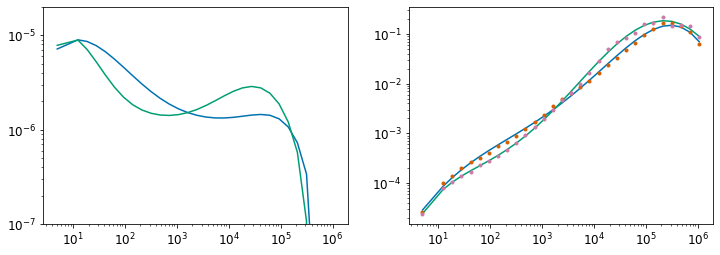

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['V_ll'])
plt.plot(SF_GLAD['r'], SF_GLAD['V_tt'])
plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-7, 2e-5])

plt.subplot(122)
plt.plot(SF_GLAD['r'], SF_GLAD['fll_fit'])
plt.plot(SF_GLAD['r'], SF_GLAD['ftt_fit'])
plt.plot(SF_GLAD['r'], SF_GLAD['S2ll'], '.')
plt.plot(SF_GLAD['r'], SF_GLAD['S2tt'], '.')
plt.xscale('log')
plt.yscale('log')


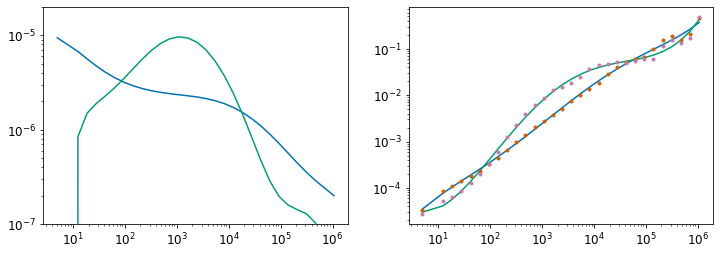

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(SF_LASER['r'], SF_LASER['V_ll'])
plt.plot(SF_LASER['r'], SF_LASER['V_tt'])
plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-7, 2e-5])

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['fll_fit'])
plt.plot(SF_LASER['r'], SF_LASER['ftt_fit'])
plt.plot(SF_LASER['r'], SF_LASER['S2ll'], '.')
plt.plot(SF_LASER['r'], SF_LASER['S2tt'], '.')
plt.xscale('log')
plt.yscale('log')


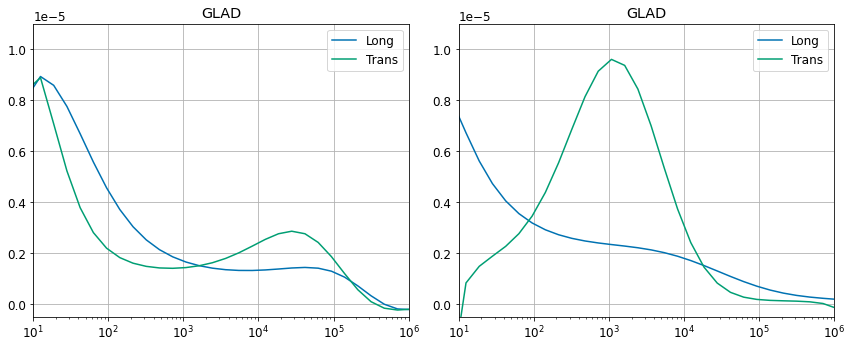

In [16]:
# V(r)
plt.figure(figsize=(12,5 ))


plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['V_ll'], label='Long')
plt.plot(SF_GLAD['r'], SF_GLAD['V_tt'], label='Trans')
plt.xscale('log')
#plt.yscale('log')
plt.ylim([-5e-7, 11e-6])
plt.xlim([10, 1e6])
plt.grid()
plt.legend()
plt.title('GLAD')

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['V_ll'], label='Long')
plt.plot(SF_LASER['r'], SF_LASER['V_tt'], label='Trans')
plt.xscale('log')
#plt.yscale('log')
plt.ylim([-5e-7, 11e-6])
plt.xlim([10, 1e6])
plt.grid()
plt.legend()
plt.title('GLAD')

plt.tight_layout()

In [32]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


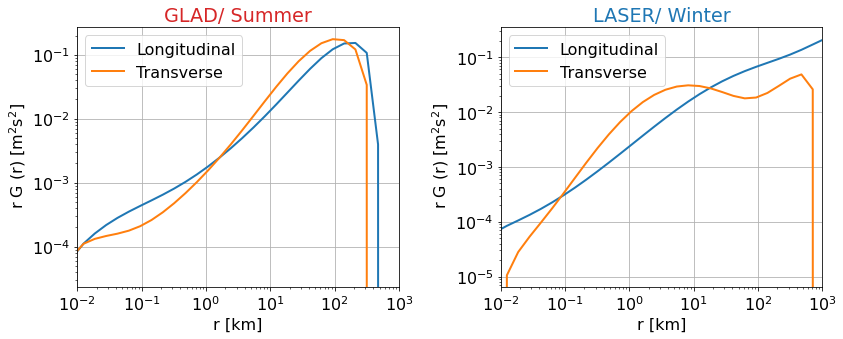

In [33]:
#r V(r)
plt.figure(figsize=(12,5 ))


plt.subplot(121)
plt.plot(SF_GLAD['r']/1e3, SF_GLAD['r']*SF_GLAD['V_ll'], label='Longitudinal', linewidth=2, color='tab:blue')
plt.plot(SF_GLAD['r']/1e3, SF_GLAD['r']*SF_GLAD['V_tt'], label='Transverse', linewidth=2, color='tab:orange')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([0.01, 1e3])
plt.grid()
plt.legend()
plt.xlabel('r [km]')
plt.ylabel(' r G (r) [m$^2$s$^2$]')
plt.title('GLAD/ Summer', color='tab:red')

plt.subplot(122)
plt.plot(SF_LASER['r']/1e3, SF_LASER['r']*SF_LASER['V_ll'], label='Longitudinal', linewidth=2, color='tab:blue')
plt.plot(SF_LASER['r']/1e3, SF_LASER['r']*SF_LASER['V_tt'], label='Transverse', linewidth=2, color='tab:orange')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([0.01, 1e3])
plt.grid()
plt.legend()
plt.title('LASER/ Winter', color='tab:blue')
plt.xlabel('r [km]')
plt.ylabel(' r G (r) [m$^2$s$^2$]')
plt.tight_layout()

plt.savefig('lon-tran_sig_func.pdf')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


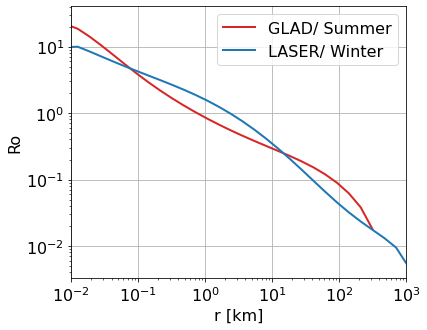

In [35]:
# Rossby number
plt.figure(figsize=(6,5 ))

f = 2 * (2*np.pi/24/3600) * np.sin(27*np.pi/180);  

#plt.subplot(121)
plt.plot(SF_GLAD['r']/1e3, (SF_GLAD['r']*SF_GLAD['V_tot'])**0.5/f/SF_GLAD['r'], 
         label='GLAD/ Summer', linewidth=2, color='tab:red')
plt.plot(SF_LASER['r']/1e3, (SF_GLAD['r']*SF_LASER['V_tot'])**0.5/f/SF_GLAD['r'], 
         label='LASER/ Winter', linewidth=2, color='tab:blue')

#plt.plot(SF_GLAD['r'], SF_GLAD['r']*SF_GLAD['V_tt'], label='Trans')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([0.01, 1e3])
plt.grid()
plt.legend()
plt.ylabel('Ro')
plt.xlabel('r [km]')

plt.savefig('Ro_sig_funcs.pdf')

How well fitting took place for rotational and divergent parts.

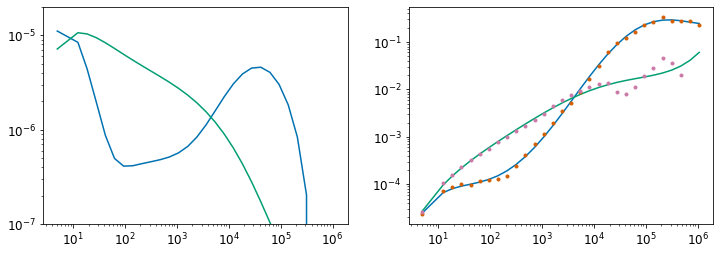

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['V_rr'])
plt.plot(SF_GLAD['r'], SF_GLAD['V_dd'])
plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-7, 2e-5])

plt.subplot(122)
plt.plot(SF_GLAD['r'], SF_GLAD['frr_fit'])
plt.plot(SF_GLAD['r'], SF_GLAD['fdd_fit'])
plt.plot(SF_GLAD['r'], SF_GLAD['S2rr'], '.')
plt.plot(SF_GLAD['r'], SF_GLAD['S2dd'], '.')
plt.xscale('log')
plt.yscale('log')


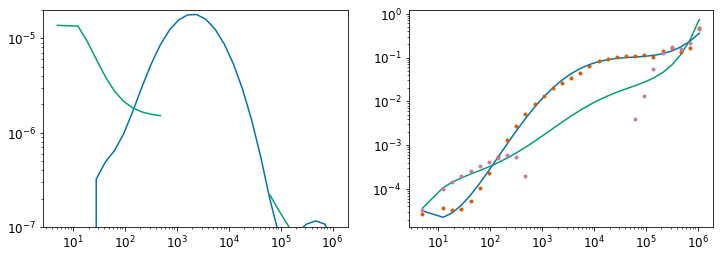

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(SF_LASER['r'], SF_LASER['V_rr'])
plt.plot(SF_LASER['r'], SF_LASER['V_dd'])
plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-7, 2e-5])

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['frr_fit'])
plt.plot(SF_LASER['r'], SF_LASER['fdd_fit'])
plt.plot(SF_LASER['r'], SF_LASER['S2rr'], '.')
plt.plot(SF_LASER['r'], SF_LASER['S2dd'], '.')
plt.xscale('log')
plt.yscale('log')


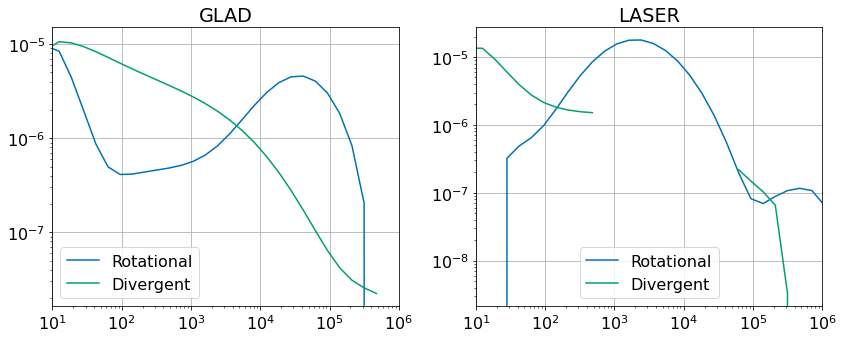

In [36]:
# V(r)
plt.figure(figsize=(12,5 ))

plt.subplot(121)
plt.plot(SF_GLAD['r'], SF_GLAD['V_rr'], label='Rotational')
plt.plot(SF_GLAD['r'], SF_GLAD['V_dd'], label='Divergent')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([10, 1e6])
plt.grid()
plt.legend()
plt.title('GLAD')

plt.subplot(122)
plt.plot(SF_LASER['r'], SF_LASER['V_rr'], label='Rotational')
plt.plot(SF_LASER['r'], SF_LASER['V_dd'], label='Divergent')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([10, 1e6])
plt.grid()
plt.legend()
plt.title('LASER')

plt.tight_layout()

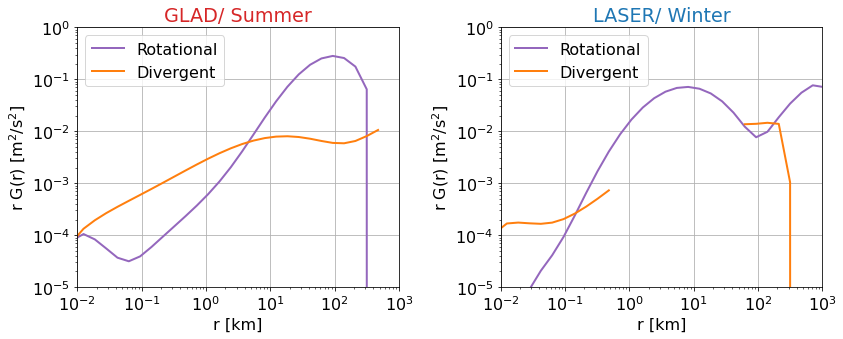

In [41]:
# rV(r)
plt.figure(figsize=(12,5 ))


plt.subplot(121)
plt.plot(SF_GLAD['r']/1e3, SF_GLAD['r']*SF_GLAD['V_rr'], label='Rotational',
        linewidth=2, color='tab:purple')
plt.plot(SF_GLAD['r']/1e3, SF_GLAD['r']*SF_GLAD['V_dd'], label='Divergent',
        linewidth=2, color='tab:orange')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([.01, 1e3])
plt.ylim([1e-5, 1])
plt.grid()
plt.legend()
plt.xlabel('r [km]')
plt.ylabel('r G(r) [m$^2$/s$^2$]')
plt.title('GLAD/ Summer', color='tab:red')

plt.subplot(122)
plt.plot(SF_LASER['r']/1e3, SF_LASER['r']*SF_LASER['V_rr'], label='Rotational',
        linewidth=2, color='tab:purple')
plt.plot(SF_LASER['r']/1e3, SF_LASER['r']*SF_LASER['V_dd'], label='Divergent',
        linewidth=2, color='tab:orange')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([-5e-7, 11e-6])
plt.xlim([.01, 1e3])
plt.ylim([1e-5, 1])
plt.grid()
plt.legend()
plt.title('LASER/ Winter', color='tab:blue')
plt.xlabel('r [km]')
plt.ylabel('r G(r) [m$^2$/s$^2$]')

plt.tight_layout()
plt.savefig('Rot-Div_sig_funcs.pdf')

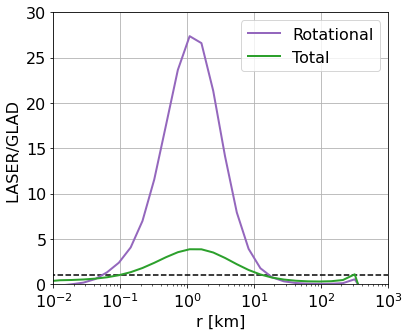

In [40]:
# Ratios
plt.figure(figsize=(6,5))
plt.plot(SF_GLAD['r']/1e3, SF_LASER['V_rr']/ SF_GLAD['V_rr'], label='Rotational',
        linewidth=2, color='tab:purple')

plt.plot( SF_GLAD['r']/1e3, (SF_LASER['V_ll']+ SF_LASER['V_tt'])/ (SF_GLAD['V_ll']+ SF_GLAD['V_tt']) ,
         label='Total', linewidth=2, color='tab:green')

plt.hlines(1, 1/1e3, 1e6/1e3, colors='k', linestyles='--')
plt.xscale('log')
plt.grid()
plt.ylim([0, 30])
plt.xlim([0.01, 1e3])
plt.legend()

plt.ylabel('LASER/GLAD ')
plt.xlabel('r [km]')

plt.savefig('Ratio_sig_funcs.pdf')

#### Scraps 

Originally tried to fit cubic splines, but the result was too noisy. 

In [ ]:
cs_ll = CubicSpline(x,yll)
cs_tt = CubicSpline(x,ytt)

In [ ]:
poly3_ll = np.polyfit(np.log(x), np.log(yll), 6)
pf_ll = np.poly1d(poly3_ll)

poly3_tt = np.polyfit(np.log(x), np.log(ytt), 6)
pf_tt = np.poly1d(poly3_tt)

In [ ]:
plt.plot(x, yll, '.')
plt.plot(x, cs_ll(x))
plt.plot(x, pf_ll(x))

plt.plot(x, ytt, '.')
plt.plot(x, cs_tt(x))
plt.plot(x, pf_tt(x))


In [ ]:
plt.plot(np.log(x), pf_ll(np.log(x)))
plt.plot(np.log(x), np.log(yll), '.')

plt.plot(np.log(x), pf_tt(np.log(x)))
plt.plot(np.log(x), np.log(ytt), '.')


In [ ]:
pf_ll.deriv()

In [ ]:
plt.plot(x, cs_ll(x))
plt.plot(x, (pf_ll(x)))


plt.plot(x, cs_tt(x))
plt.plot(x, pf_tt(x))


plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(x, cs_ll(x,1))
plt.plot(x, cs_tt(x,1))

plt.xscale('log')
plt.yscale('log')

In [ ]:
Vll = -x* cs_ll(x,2) + cs_ll(x,1)
Vtt = -x* cs_tt(x,2) + cs_tt(x,1)


In [ ]:
plt.plot(x, Vll)
plt.plot(x, Vtt)

plt.xscale('log')
#plt.yscale('log')